In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

### Reading the trainingLabels and finding whether the corresponding image exists in the directory
    - splitting the patient id from image name
    - path from image
    - checks the existence of image
    - from file name check whether it's left or right (1 for left, 0 for right)
    - level of DR
    - Total Available images are 22129

In [2]:
base_data_dir = os.path.join('data')
image_dir = os.path.join('data', 'images')
retina_df = pd.read_csv(os.path.join(base_data_dir, 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

22129 images found of 35126 total


Using TensorFlow backend.


,image,level,PatientId,path,exists,eye,level_cat
2778,3447_left,0,3447,data/images/3447_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
27595,34931_right,0,34931,data/images/34931_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
16681,20948_right,0,20948,data/images/20948_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"


### Checking the distribution for each eye in the available dataset
    - We can see the data is equally distributed with 4204 on each side
    - looking at the level distribution it's uneven, data is maximum available for level 1 followed by level 2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1638393320>,
      dtype=object)

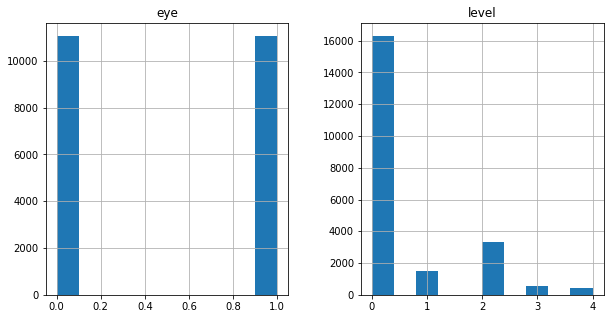

In [3]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

### Dividing the complete dataset into training and testing
    - The Training and testing dataset to 75:25 ratio
    - training data is 17121 and testing is 6036
    - we have take equal distribution for both eyes
    - we have also made sure that data for each level is available in similar distribution

In [4]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 17121 validation 6036


New Data Size: 2200 Old Size: 17121


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15fedc5c18>,
      dtype=object)

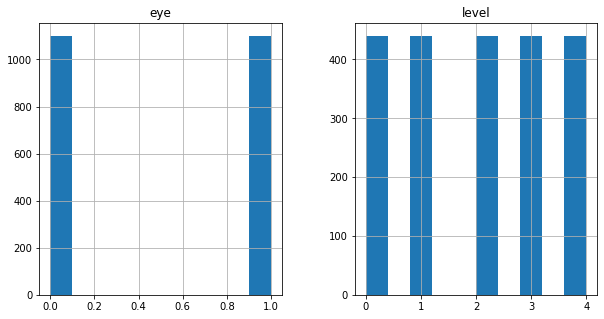

In [5]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(220, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [6]:
valid_df.shape

(6036, 7)

In [7]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        try:
            with tf.name_scope('image_augmentation'):
                with tf.name_scope('input'):

                    print('reading file {}'.format(X))
                    X = tf.io.decode_jpeg(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                    X = tf.image.resize_images(X, out_size)
                with tf.name_scope('augmentation'):
                    if horizontal_flip:
                        X = tf.image.random_flip_left_right(X)
                    if vertical_flip:
                        X = tf.image.random_flip_up_down(X)
                    if random_brightness:
                        X = tf.image.random_brightness(X, max_delta = 0.1)
                    if random_saturation:
                        X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                    if random_hue:
                        X = tf.image.random_hue(X, max_delta = 0.15)
                    if random_contrast:
                        X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                    return preproc_func(X)
        except tf.errors.InvalidArgumentError:
            print ('Poor image quality, unable to predict {}'.format(X))
            
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 5):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds, batch_size):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [8]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        batch_size = 32,
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds, batch_size).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//batch_size,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)
            
def get_iters_from_df(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        batch_size = 32,
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0).astype(np.float32)))
    in_len = in_df[path_col].values.shape[0]
    if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
    idg_batches = idg(files_ds, batch_size)
    img_batch = idg_batches.map(lambda x,y: x).repeat()
    val_batch = idg_batches.map(lambda x,y: y).repeat()
    return img_batch.make_one_shot_iterator().get_next(), val_batch.make_one_shot_iterator().get_next()

In [9]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        ) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat',
                               batch_size = batch_size)

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat',
                               batch_size = batch_size)

### Display raw images jus by resizing it to 512, 512 as the actual image is huge
   - we can see all the samples from each **Severity** Level ranging from 0,1,2,3 
    - 0 - No DR. No abnormalities present.
    - 1 - Mild. Microaneurysms only.
    - 2 - Moderate. More than just microaneurysms.
    - 3 - Severe. Any of the following: >20 intraretinal hemorrhages in each of 4 quadrants, definite venous beading in 2+ quadrants, prominent in- traretinal microvascular abnormalities (IRMA) in 1+ quadrant.
    - 4 - Proliferative DR. Either neovascularization or vitreous/preretinal hem- orrhage. Or both of them.

W0817 10:41:40.040243 139734487856896 deprecation.py:323] From <ipython-input-8-6cb4c6ac27c7>:15: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0817 10:41:40.074381 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0817 10:41:40.075110 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use 

reading file Tensor("args_0:0", shape=(), dtype=string)


W0817 10:41:40.177221 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



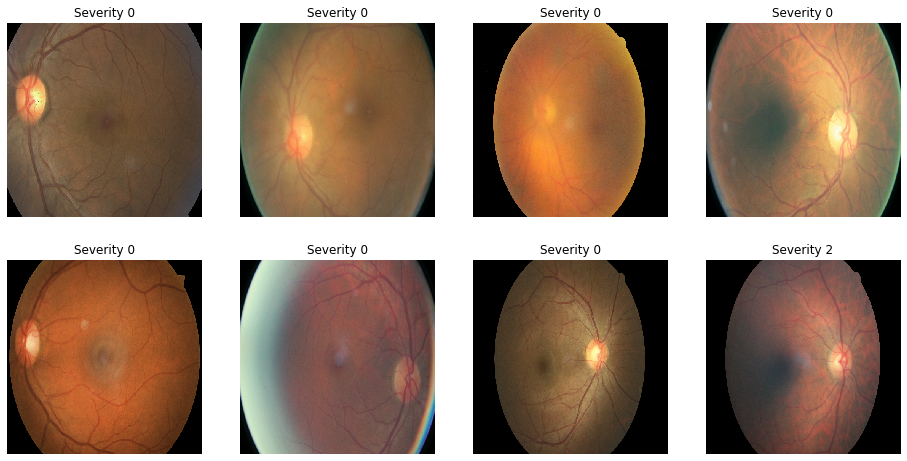

In [10]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

### Display Augmented images to see the difference of applied augmentations like
   - Rotation
    - Crop
    - Contrast
    - brightness
    - Flip

reading file Tensor("args_0:0", shape=(), dtype=string)


W0817 10:41:44.405663 139734487856896 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



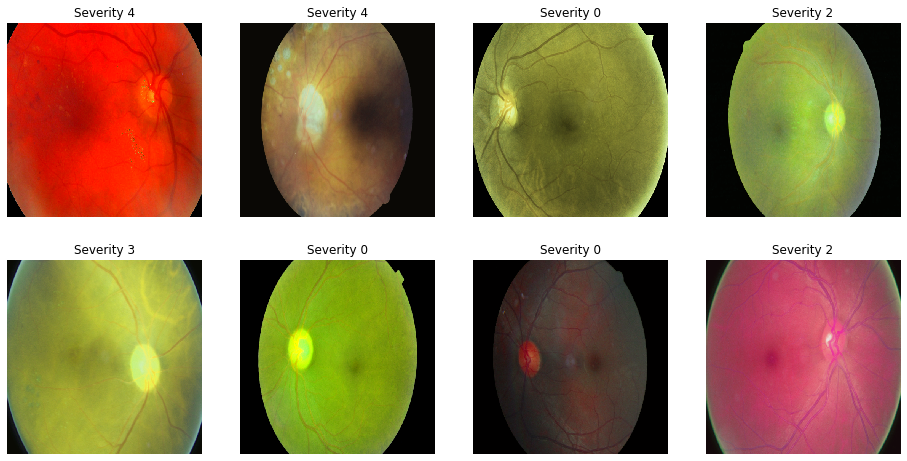

In [11]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [12]:
img_iter, cat_iter = get_iters_from_df(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat',
                               batch_size = batch_size)

reading file Tensor("args_0:0", shape=(), dtype=string)


In [13]:
print('t_x.shape[1:] {}'.format(t_x.shape[1:]))
print('img_iter {}'.format(img_iter.shape[1:]))

t_x.shape[1:] (512, 512, 3)
img_iter (512, 512, 3)


In [14]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model

in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization

flatten = Flatten()(pt_features)

fully_connected = Dense(500, activation = 'relu')(Dropout(0.5)(flatten))
normalized = BatchNormalization()(fully_connected)
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(normalized)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

W0817 10:41:50.238897 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 10:41:51.621783 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0817 10:41:51.844823 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 10:41:52.601859 139734487856896 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               200704500 
_________________________________________________________________
batch_normalization_95 (Batc (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total para

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = 25,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

W0817 10:42:27.490038 139734487856896 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
25/25 [==============================] - 281s 11s/step - loss: 2.2876 - categorical_accuracy: 0.2900 - top_2_accuracy: 0.5042 - val_loss: 1.4379 - val_categorical_accuracy: 0.4947 - val_top_2_accuracy: 0.7682

Epoch 00001: loss improved from inf to 2.28758, saving model to retina_weights.best.hdf5
Epoch 2/25
25/25 [==============================] - 264s 11s/step - loss: 1.5778 - categorical_accuracy: 0.3425 - top_2_accuracy: 0.5767 - val_loss: 1.2157 - val_categorical_accuracy: 0.5278 - val_top_2_accuracy: 0.7825

Epoch 00002: loss improved from 2.28758 to 1.57782, saving model to retina_weights.best.hdf5
Epoch 3/25
25/25 [==============================] - 260s 10s/step - loss: 1.3754 - categorical_accuracy: 0.4183 - top_2_accuracy: 0.6583 - val_loss: 1.0455 - val_categorical_accuracy: 0.6675 - val_top_2_accuracy: 0.8122

Epoch 00003: loss improved from 1.57782 to 1.37543, saving model to retina_weights.best.hdf5
Epoch 4/25
25/25 [==============================] - 265s 11s/s

25/25 [==============================] - 265s 11s/step - loss: 1.0195 - categorical_accuracy: 0.5992 - top_2_accuracy: 0.8050 - val_loss: 1.1015 - val_categorical_accuracy: 0.5428 - val_top_2_accuracy: 0.8023

Epoch 00015: loss improved from 1.07377 to 1.01951, saving model to retina_weights.best.hdf5
Epoch 16/25
25/25 [==============================] - 260s 10s/step - loss: 1.0104 - categorical_accuracy: 0.6008 - top_2_accuracy: 0.8058 - val_loss: 1.0886 - val_categorical_accuracy: 0.5607 - val_top_2_accuracy: 0.8098

Epoch 00016: loss improved from 1.01951 to 1.01036, saving model to retina_weights.best.hdf5
Epoch 17/25
25/25 [==============================] - 266s 11s/step - loss: 1.0104 - categorical_accuracy: 0.6017 - top_2_accuracy: 0.8242 - val_loss: 1.1491 - val_categorical_accuracy: 0.5052 - val_top_2_accuracy: 0.7747

Epoch 00017: loss did not improve from 1.01036
Epoch 18/25
24/25 [===========================>..] - ETA: 2s - loss: 0.9944 - categorical_accuracy: 0.5868 - top_

In [18]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [19]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

reading file Tensor("args_0:0", shape=(), dtype=string)



In [67]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X[:50], batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y[:50], -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

50/50 [==============================] - 2s 32ms/step
Accuracy on Test Data: 0.78%
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        39
           1       0.25      0.25      0.25         4
           2       1.00      0.14      0.25         7

    accuracy                           0.78        50
   macro avg       0.69      0.45      0.46        50
weighted avg       0.80      0.78      0.74        50



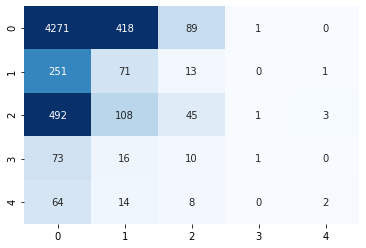

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_Y_cat, pred_Y_cat)
sns.heatmap(cm, 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)


In [59]:
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9108551930049051
Specificity :  0.2204968944099379


Text(0, 0.5, 'True Positive Rate')

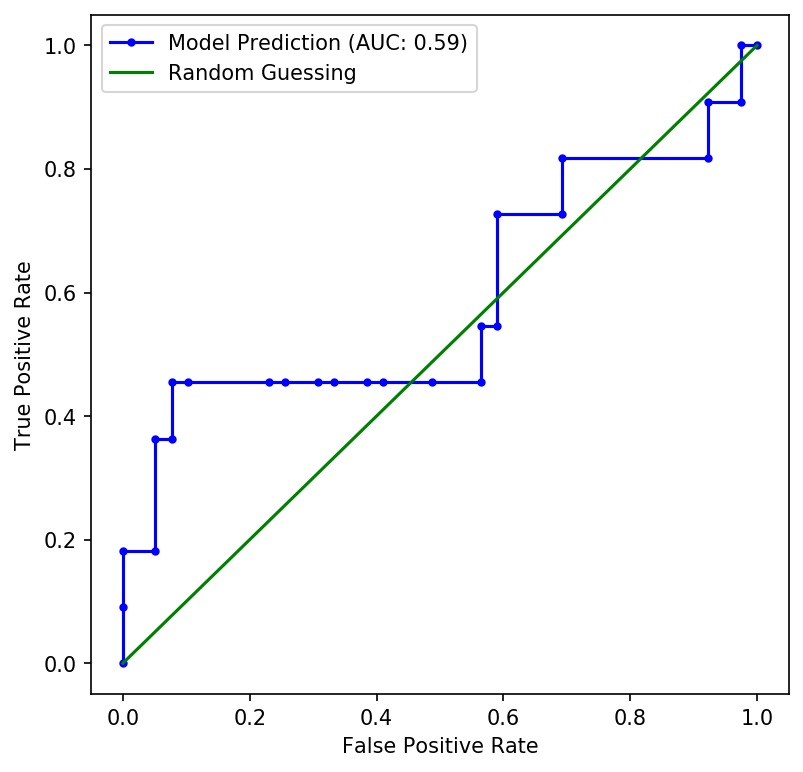

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')